# Импорт библиотек

In [173]:
!pip install pycountry

import pycountry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Загрузка датасета и первичный анализ

In [174]:
salaries = pd.read_csv('salaries.csv')
salaries

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Data Scientist,132600,USD,132600,US,100,US,M
1,2025,MI,FT,Data Scientist,102000,USD,102000,US,100,US,M
2,2025,SE,FT,Data Product Manager,260520,USD,260520,US,0,US,M
3,2025,SE,FT,Data Product Manager,140280,USD,140280,US,0,US,M
4,2025,SE,FT,Machine Learning Engineer,215000,USD,215000,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
136752,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
136753,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
136754,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
136755,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [175]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136757 entries, 0 to 136756
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           136757 non-null  int64 
 1   experience_level    136757 non-null  object
 2   employment_type     136757 non-null  object
 3   job_title           136757 non-null  object
 4   salary              136757 non-null  int64 
 5   salary_currency     136757 non-null  object
 6   salary_in_usd       136757 non-null  int64 
 7   employee_residence  136757 non-null  object
 8   remote_ratio        136757 non-null  int64 
 9   company_location    136757 non-null  object
 10  company_size        136757 non-null  object
dtypes: int64(4), object(7)
memory usage: 11.5+ MB


In [176]:
salaries.nunique()

,0
work_year,6
experience_level,4
employment_type,4
job_title,398
salary,11444
salary_currency,26
salary_in_usd,12651
employee_residence,102
remote_ratio,3
company_location,95


In [177]:
salaries.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,136757.000000,1.367570e+05,136757.000000,136757.000000
mean,2024.374686,1.630432e+05,157490.722756,20.909716
std,0.679644,2.150435e+05,74173.546839,40.594326
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2024.000000,1.060000e+05,105900.000000,0.000000
50%,2024.000000,1.470000e+05,146000.000000,0.000000
75%,2025.000000,1.988000e+05,197800.000000,0.000000
max,2025.000000,3.040000e+07,800000.000000,100.000000


# Обогащение

In [178]:
salaries['salary_per_hour'] = salaries['salary_in_usd'] / 2000 # 250 рабочих дней * 8 рабочих часов
salaries['job_format'] = salaries['remote_ratio'].apply(
    lambda x: 'On-site' if x == 0 else 'Hybrid' if x == 50 else 'Remote'
)

In [179]:
def iso_to_country_name(iso_code):
    try:
        return pycountry.countries.get(alpha_2=iso_code).name
    except:
        return None

salaries['country_name'] = salaries['company_location'].apply(iso_to_country_name)
salaries.dropna(subset=['country_name'], inplace=True)

# Численный анализ

Средняя заработная плата по типу трудоустройства

In [180]:
avg_salaries_by_type = salaries.groupby('employment_type').agg({'salary_in_usd': 'mean'}).sort_values('salary_in_usd', ascending=False)
avg_salaries_by_type

,salary_in_usd
employment_type,
FT,157895.439667
CT,102545.556373
PT,76372.875661
FL,50651.562500


Средняя заработная плата по годам

In [181]:
avg_salaries_by_year = salaries.groupby('work_year').agg({'salary_in_usd': 'mean'}).sort_values('salary_in_usd', ascending=False)
avg_salaries_by_year

,salary_in_usd
work_year,
2024,159590.943638
2025,156825.555623
2023,153686.763933
2022,134146.471403
2020,102250.866667
2021,99922.073394


Средняя заработная плата по опыту

In [182]:
avg_salaries_by_expirience = salaries.groupby('experience_level').agg({'salary_in_usd': 'mean'}).sort_values('salary_in_usd', ascending=False)
avg_salaries_by_expirience

,salary_in_usd
experience_level,
EX,202057.392943
SE,172700.323329
MI,142885.353136
EN,99047.595918


Топ-10 высооплачиваемых профессий

In [183]:
top_jobs = (
    salaries
    .groupby(['job_title', 'work_year'])['salary_in_usd']
    .mean()
    .reset_index()
    .sort_values(by='salary_in_usd', ascending=False)
    .head(10)
)
top_jobs

,job_title,work_year,salary_in_usd
696,Research Team Lead,2025,450000.0
246,Data Analytics Lead,2022,405000.0
76,Analytics Engineering Manager,2023,399880.0
385,Data Science Tech Lead,2022,375000.0
496,Head of Machine Learning,2024,334000.0
83,Applied AI ML Lead,2024,292500.0
499,IT Enterprise Data Architect,2025,284090.0
450,Director of Data,2025,277500.0
9,AI Developer,2022,275000.0
486,Head of Applied AI,2025,273875.0


# Визуальный анализ

Распределение форматов работы

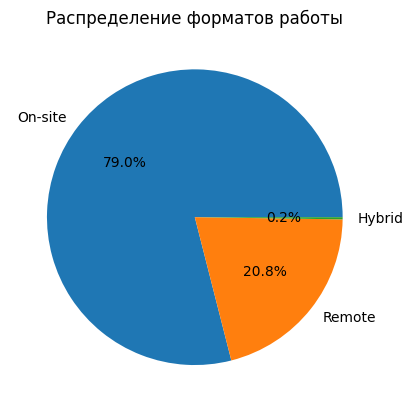

In [184]:
plt.pie(salaries['job_format'].value_counts(), labels=salaries['job_format'].value_counts().index, autopct='%1.1f%%')
plt.title('Распределение форматов работы')
plt.show()

Распределение опыта специалистов

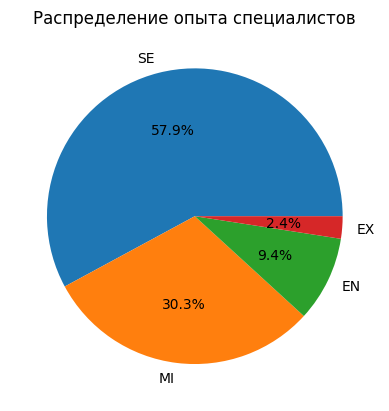

In [185]:
plt.pie(salaries['experience_level'].value_counts(), labels=salaries['experience_level'].value_counts().index, autopct='%1.1f%%')
plt.title('Распределение опыта специалистов')
plt.show()

Средние зарплаты за год

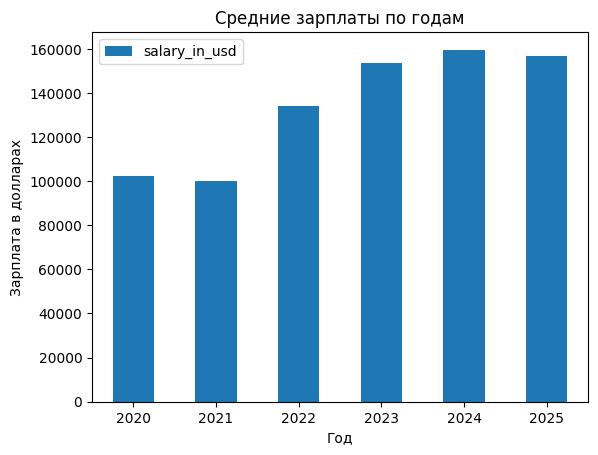

In [186]:
avg_salaries_by_year.sort_values(by='work_year', ascending=True).plot(kind='bar')
plt.title('Средние зарплаты по годам')
plt.xlabel('Год')
plt.ylabel('Зарплата в долларах')
plt.xticks(rotation=0)
plt.show()

Средние зарплаты по опыту работы

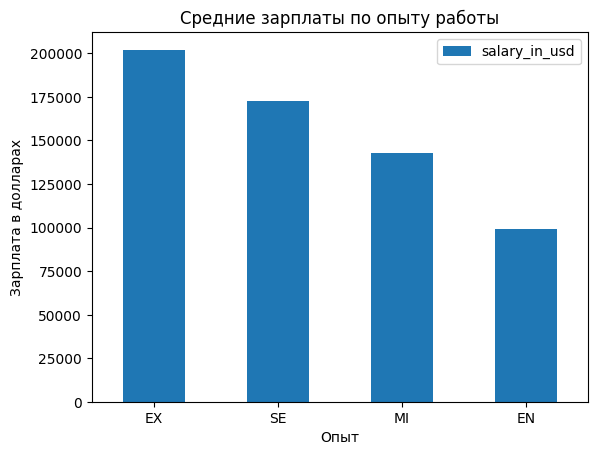

In [187]:
avg_salaries_by_expirience.plot(kind='bar')
plt.title('Средние зарплаты по опыту работы')
plt.xlabel('Опыт')
plt.ylabel('Зарплата в долларах')
plt.xticks(rotation=0)
plt.show()

Boxplot по зарплатам

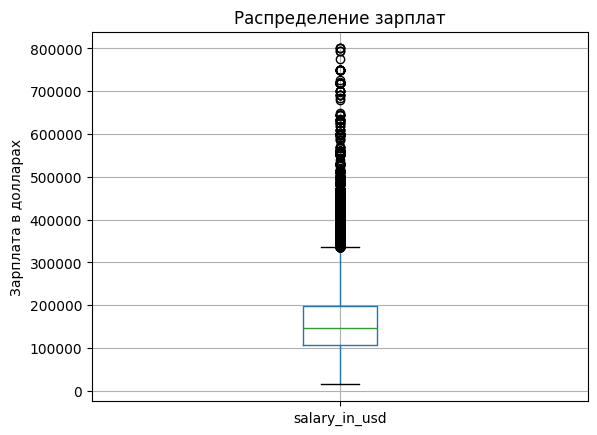

In [188]:
salaries.boxplot(column='salary_in_usd')
plt.title('Распределение зарплат')
plt.ylabel('Зарплата в долларах')
plt.grid(True)
plt.show()

Heatmap по должностям, зарплатам и remote_ratio

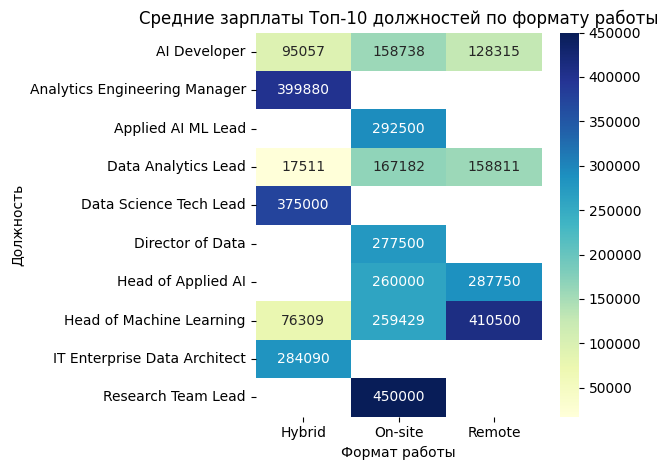

In [189]:
filtered = salaries[salaries['job_title'].isin(top_jobs['job_title'])]

pivot_table = filtered.pivot_table(
    index='job_title',
    columns='job_format',
    values='salary_in_usd',
    aggfunc='mean'
)

sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Средние зарплаты Топ-10 должностей по формату работы")
plt.xlabel("Формат работы")
plt.ylabel("Должность")
plt.tight_layout()
plt.show()

# Прогнозирование средних зарплат в долларах по формату работы

In [190]:
grouped = salaries.groupby(['work_year', 'remote_ratio'])['salary_in_usd'].mean().reset_index()
grouped

,work_year,remote_ratio,salary_in_usd
0,2020,0,94258.111111
1,2020,50,86879.142857
2,2020,100,115214.083333
3,2021,0,106835.758621
4,2021,50,81311.821918
5,2021,100,109905.275862
6,2022,0,135055.032394
7,2022,50,83217.937500
8,2022,100,137093.875986
9,2023,0,157239.378701


In [191]:
grouped['log_salary'] = np.log1p(grouped['salary_in_usd']) # Логарифмируем, чтобы уменьшить влияение выбросов,
# которые нельзя исключить из датасета

X_train = grouped[['work_year', 'remote_ratio']]
y_train = grouped['log_salary']

In [192]:
model = XGBRegressor(objective='reg:gamma')
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:gamma', ...)

In [193]:
score = cross_val_score(model, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=5)
rmse_score = np.sqrt(-score)
print(f"RMSE при кросс-валидации: {rmse_score.mean():.2f} ± {rmse_score.std():.2f}")

RMSE при кросс-валидации: 0.09 ± 0.05


In [194]:
X_pred = pd.DataFrame([[2026, 0]], columns=['work_year', 'remote_ratio'])
pred1 = np.expm1(model.predict(X_pred))
X_pred = pd.DataFrame([[2026, 50]], columns=['work_year', 'remote_ratio'])
pred2 = np.expm1(model.predict(X_pred))
X_pred = pd.DataFrame([[2026, 100]], columns=['work_year', 'remote_ratio'])
pred3 = np.expm1(model.predict(X_pred))

new_rows = pd.DataFrame({'work_year': [2026, 2026, 2026], 'remote_ratio': [0, 50, 100], 'salary_in_usd': [pred1[0], pred2[0], pred3[0]]})

predicted_salaries = pd.concat([grouped, new_rows], ignore_index=True)
predicted_salaries.drop(columns=['log_salary'], inplace=True)
predicted_salaries

,work_year,remote_ratio,salary_in_usd
0,2020,0,94258.111111
1,2020,50,86879.142857
2,2020,100,115214.083333
3,2021,0,106835.758621
4,2021,50,81311.821918
5,2021,100,109905.275862
6,2022,0,135055.032394
7,2022,50,83217.937500
8,2022,100,137093.875986
9,2023,0,157239.378701


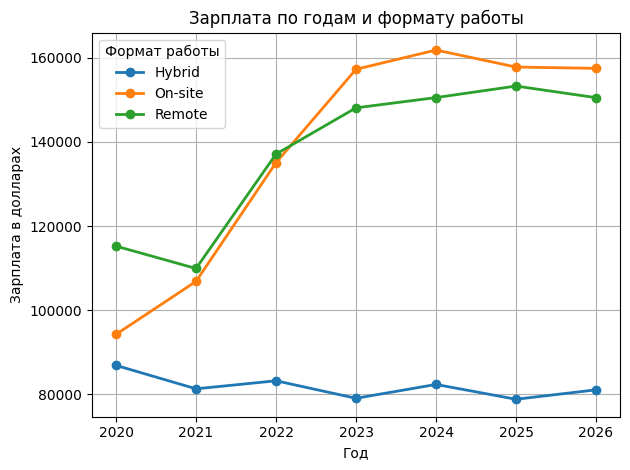

In [195]:
predicted_salaries['job_format'] = predicted_salaries['remote_ratio'].apply(
    lambda x: 'On-site' if x == 0 else 'Hybrid' if x == 50 else 'Remote'
)

pivot_table = predicted_salaries.pivot_table(
    index='job_format',
    columns='work_year',
    values='salary_in_usd',
    aggfunc='mean'
)

df_plot = pivot_table.T
colors = {ratio: plt.cm.tab10(i) for i, ratio in enumerate(df_plot.columns)}

ax = df_plot.plot(
    color=[colors[col] for col in df_plot.columns],
    marker='o',
    linewidth=2
)

ax.set_xlabel('Год')
ax.set_ylabel('Зарплата в долларах')
ax.set_title('Зарплата по годам и формату работы')
ax.legend(title='Формат работы', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [196]:
salaries.to_excel('salaries.xlsx', sheet_name='salaries', index=False)

In [197]:
predicted_salaries.to_excel('predict.xlsx', sheet_name='predict', index=False)